In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from collections import Counter
from tensorflow.keras.layers import Embedding, Dropout, Dense, Bidirectional, LSTM, BatchNormalization, Activation
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import optimizers


import os.path

path = ''
if not os.path.isfile('001_Data_retrieve.ipynb'):
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/TRABAJO/Data Science/ITBA-DeepLearning/Notebooks/TP-FINAL/bioinformatics_final_project'

# Modelo Recurrentes con Embeddings a nivel de caracter

In [6]:
df = pd.read_csv(path+'/data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [8]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


# Canonical_smiles To secuence

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Utilizando Tokenizer y pad_sequences de keras a nivel de caracter, obtener la entrada tokenizada. Por ejemplo:

**El smiles**:

'C[C@@]12CC[C@H]3[C@]4(C)CCC[C@@]5(C)C(=O)OCC[N+](C)(C)CCCCCCCCC[N+](C)(C)CCOC(=O)[C@]6(C)CCC[C@]7(C)[C@@H]6CC[C@@]68C[C@@H](OC(=O)CCCCCCCCC(=O)O[C@@H]1C[C@@]3(CC[C@@H]45)C2)[C@@](C)(CC[C@@H]76)C8.[Br-].[Br-]'

**Tendría que quedar algo asi (puede que no sea exacto):**

array([ 2, 11,  2, 13, 13, 12,  5,  7,  2,  2, 11,  2, 13, 16, 12, 10, 11,
        2, 13, 12, 15,  3,  2,  4,  2,  2,  2, 11,  2, 13, 13, 12, 23,  3,
        2,  4,  2,  3,  9,  6,  4,  6,  2,  2, 11,  8, 21, 12,  3,  2,  4,
        3,  2,  4,  2,  2,  2,  2,  2,  2,  2,  2,  2, 11,  8, 21, 12,  3,
        2,  4,  3,  2,  4,  2,  2,  6,  2,  3,  9,  6,  4, 11,  2, 13, 12,
       30,  3,  2,  4,  2,  2,  2, 11,  2, 13, 12, 35,  3,  2,  4, 11,  2,
       13, 13, 16, 12, 30,  2,  2, 11,  2, 13, 13, 12, 30, 36,  2, 11,  2,
       13, 13, 16, 12,  3,  6,  2,  3,  9,  6,  4,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  9,  6,  4,  6, 11,  2, 13, 13, 16, 12,  5,  2, 11,
        2, 13, 13, 12, 10,  3,  2,  2, 11,  2, 13, 13, 16, 12, 15, 23,  4,
        2,  7,  4, 11,  2, 13, 13, 12,  3,  2,  4,  3,  2,  2, 11,  2, 13,
       13, 16, 12, 35, 30,  4,  2, 36, 20, 11, 25, 26, 17, 12, 20, 11, 25,
       26, 17, 12], dtype=int32)
       

**Otro ejemplo:**
smiles: 'NC(=O)O'

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 8, 2, 3, 9, 6, 4, 6], dtype=int32)

**Tener en cuenta:**

- Ver cuanta es la máxima longitud para agregar el padding correspondiente
- En el ejemplo se agrego padding a la izquierda

In [10]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
print('max longitud: ',max_len_idx)
print('min longitud: ',min_len_idx)

max longitud:  2929
min longitud:  595


In [11]:
long_max_smile  =len(df.iloc[max_len_idx].canonical_smiles)
long_max_smile

207

In [12]:
#cant de caracteres
# Uno todos las cadenas smile en una sola
text = ''
for cs in df['canonical_smiles']:
    text = text + cs
vocab_hist = dict(Counter(text))
cant_caracteres = len(vocab_hist) +1

In [13]:
X = df['canonical_smiles']
y = df['pIC50']

In [14]:
print('cant. de caracteres de smile: ', cant_caracteres)
print('long. maxima de smile: ', long_max_smile)

cant. de caracteres de smile:  39
long. maxima de smile:  207


In [15]:
# Implementar tokenización y guardar en X_seq_pad el dataset 
tokenizer_inputs = Tokenizer(num_words=cant_caracteres, char_level=True)
tokenizer_inputs.fit_on_texts(df['canonical_smiles'])
df['X_seq'] = tokenizer_inputs.texts_to_sequences(df['canonical_smiles']) #input tokenizado

df['X_seq_pad'] =  pad_sequences(df.X_seq, maxlen=long_max_smile, padding='pre', value=0).tolist()
X_seq_pad = pad_sequences(df.X_seq, maxlen=long_max_smile, padding='pre', value=0).tolist()
y =df['pIC50'].values
#X_seq_pad = df['X_seq_pad'].values

In [16]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50,X_seq,X_seq_pad
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939,"[1, 1, 6, 1, 4, 5, 5, 2, 15, 1, 7, 1, 1, 1, 1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000,"[6, 8, 1, 2, 5, 4, 1, 1, 1, 1, 1, 4, 3, 5, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030,"[1, 5, 2, 1, 2, 8, 6, 3, 5, 4, 5, 1, 2, 15, 1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879,"[6, 8, 1, 2, 5, 4, 1, 1, 1, 1, 1, 4, 3, 5, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910,"[1, 22, 1, 4, 5, 1, 2, 15, 1, 7, 1, 1, 1, 2, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df.to_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed_tokenizada.csv', index=False)

# Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_seq_pad, y, test_size=0.2, random_state=42)

In [19]:
len(X_train), len(y_train), len(X_test)

(4082, 4082, 1021)

# Network Model

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

In [21]:
# Métrica

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [22]:
# PARAMETROS - HIPER-PARAMETROS
# vocab_size = # Completar largo del vocabulario
vocab_size = cant_caracteres
long_vec_embbeding = 64
max_sequence_len = max_len_idx # Completar
cant_neuronas_lstm = 100
cant_neuronas_hidden_layer = 50

# Armar modelo en keras de LSTM
El de abajo es un ejemplo propuesto pero puede armar otro similar (siempre con LSTM o GRU)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding (Embedding)        (None, 207, 64)           2496      
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dense (Dense)                (None, 50)                10050     
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
=================================================================
Total params: 144,797
Trainable params: 144,697
Non-trainable params: 100
_________________________________________________________________

In [23]:
model = Sequential()
# Implementar modelo completo
                    # cant caracteres, #long vect Emb, #max vocabulario   
model.add(Embedding(cant_caracteres, long_vec_embbeding, input_length=long_max_smile))
model.add(Bidirectional(LSTM(cant_neuronas_lstm)))
model.add(Dense(cant_neuronas_hidden_layer))
model.add(BatchNormalization())
model.add( Activation('relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 207, 64)           2496      
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dense (Dense)                (None, 50)                10050     
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 144,797
Trainable params: 144,697
Non-trainable params: 100
________________________________________________

In [24]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[R2])

In [25]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [26]:
history = model.fit(X_train, y_train.tolist(), epochs=100, batch_size=128, validation_data=(X_test, y_test.tolist()))

Epoch 1/100
32/32 [==============================] - 34s 951ms/step - loss: 28.6161 - R2: -9.7433 - val_loss: 29.6018 - val_R2: -9.7288
Epoch 2/100
32/32 [==============================] - 28s 887ms/step - loss: 27.4237 - R2: -9.3071 - val_loss: 28.8591 - val_R2: -9.4582
Epoch 3/100
32/32 [==============================] - 29s 892ms/step - loss: 26.9311 - R2: -9.0671 - val_loss: 27.5618 - val_R2: -8.9855
Epoch 4/100
32/32 [==============================] - 29s 892ms/step - loss: 26.6131 - R2: -9.0861 - val_loss: 27.0484 - val_R2: -8.7977
Epoch 5/100
32/32 [==============================] - 28s 889ms/step - loss: 26.4435 - R2: -9.0815 - val_loss: 26.7777 - val_R2: -8.6983
Epoch 6/100
32/32 [==============================] - 28s 890ms/step - loss: 26.3560 - R2: -8.9787 - val_loss: 26.5480 - val_R2: -8.6136
Epoch 7/100
32/32 [==============================] - 29s 893ms/step - loss: 26.3086 - R2: -8.8653 - val_loss: 26.4025 - val_R2: -8.5603
Epoch 8/100
32/32 [=============================

KeyboardInterrupt: ignored

In [27]:
y_pred = model.predict(X_test)

In [28]:
a = np.array(y_test)

In [29]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [30]:
r2
# 0.4984533246797399

-8.105043969038393

In [ ]:
# model.save('models/embed_64_bi_lstm_100_dense_50_bn.h5', )

# Load model (solo si se grabo el modelo)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# model_loaded = load_model('models/embed_64_bi_lstm_100_dense_50_bn.h5', custom_objects={'R2': R2})

In [ ]:
y_pred = model_loaded.predict(X_test)

In [ ]:
r2 = 1 - ((y_test.values - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

¿Hasta que valores de r2 logró?   --> Val_r2 = -8.10

# Evaluación

<function matplotlib.pyplot.show>

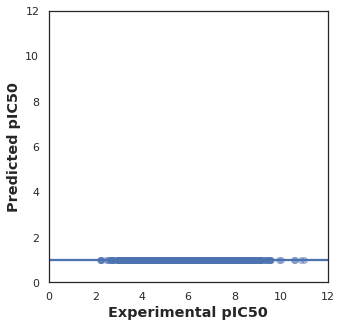

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show